In [ ]:
! pip install arabic-reshaper python-bidi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import arabic_reshaper
from bidi.algorithm import get_display
import torch
from transformers import pipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from nltk.translate.bleu_score import sentence_bleu

set_seed(42)

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print(DEVICE)

cuda


# ***preprocessing data***

In [5]:
df = pd.read_csv('data/all_poems.csv')

In [6]:
df = df[['poem_style', 'poem_text', 'poem_title', 'poet_cat', 'poet_name']]

In [7]:
df.sample(2)

,poem_style,poem_text,poem_title,poet_cat,poet_name
45216,فصحى,ان لم تعني علي شجوي فلا تلم سمعي عن العذل لو ...,إِن لَم تُعِنّي عَلى شَجوي فَلا تَلُمِ,السعودية,محمد بن عثيمين
14146,فصحى,لا تقصدن لحاجة الا امرا فرحا بنفسه اني يسر بم...,لا تَقْصِدنَّ لحاجة ٍ,العصر العباسي,ابن الرومي


In [8]:
df.isna().sum()

poem_style    0
poem_text     1
poem_title    0
poet_cat      0
poet_name     0
dtype: int64

In [9]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(58005, 5)

In [11]:
categories = df.poet_cat.value_counts()

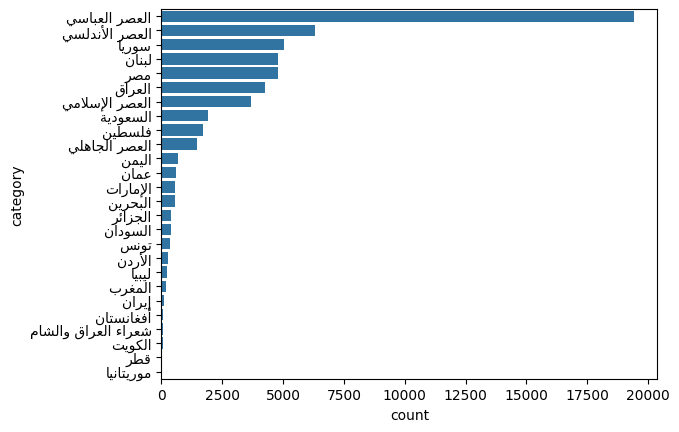

In [12]:
res2 = {get_display(arabic_reshaper.reshape(k)): v for k,v in categories.items()}
df_cat = pd.DataFrame(res2.items(), columns=['category', 'count'])
df_cat.sort_values(by='count', ascending=False, inplace=True)
ax = sns.barplot(x="count", y="category", data=df_cat)

# ***Clean Text***

In [13]:
def clean_text(text):
    text = re.sub(r'[!@#$%^&*(),.?"":{}|<>–_0-9]+', '\n ', text)
    lst = "".join([txt for txt in text.split('\n') if len(txt) != 0][0]).split(" ")[:32]
    return " ".join(lst)

In [14]:
df['poem_text'] = df['poem_text'].apply(clean_text)

In [15]:
df.head()

,poem_style,poem_text,poem_title,poet_cat,poet_name
0,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,بدر شاكر السياب
1,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,بدر شاكر السياب
2,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,بدر شاكر السياب
3,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,بدر شاكر السياب
4,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,بدر شاكر السياب


# ***Build Model using "elgeish/gpt2-medium-arabic-poetry" GPT***

In [ ]:
model_name = "elgeish/gpt2-medium-arabic-poetry"
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')

In [17]:
def generate_text(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
    input_ids.to("cuda"),
    do_sample=True,
    early_stopping=True,
    max_length=32,
    min_length=16,
    num_return_sequences=3,
    pad_token_id=50256,
    repetition_penalty=1.5,
    top_k=32,
    top_p=0.95,
)
    return tokenizer.decode(output[0], skip_special_tokens=True)




In [18]:
df = df.sample(frac=1)[:250]

In [ ]:
df['poem_generate_text'] = df['poem_text'].apply(generate_text)

# ***Evaluate Model***

In [ ]:
df['score'] = df.apply(lambda x: sentence_bleu([x['poem_text'].split(" ")], x['poem_generate_text'].split(" ")), axis=1)
df['score'] = np.round(df['score'], 3)


In [22]:
df.head()

,poem_style,poem_text,poem_title,poet_cat,poet_name,poem_generate_text,score
8562,فصحى,في زمان يصارحني لست مني واصارحه لست منك واجه...,صحراء II,سوريا,أدونيس,في زمان يصارحني لست مني واصارحه لست منك واجه...,0.953
40443,فصحى,مساء الخير يا قمرا علي افاقنا يظهر مساء الخير...,مساء الخير,السعودية,حسين احمد النجمي,مساء الخير يا قمرا علي افاقنا يظهر مساء الخير...,0.968
14087,فصحى,سقيا لايام خلت اذ لم اقل سقيا لايام خلت وعصور...,سقيا لأيامٍ خلتْ إذ لم أقل,العصر العباسي,ابن الرومي,سقيا لايام خلت اذ لم اقل سقيا لايام خلت وعصور...,0.965
12954,فصحى,الا ليت شعري هل ابيتن ليلة يروحني بالغوطتين ن...,ألا ليتَ شعرِي هلْ أبيتَنَّ ليلة ً,العصر العباسي,ابن الخياط,الا ليت شعري هل ابيتن ليلة يروحني بالغوطتين ن...,0.860
40526,فصحى,قلبي يتعلق بالاحلام ويعشق وجه البحر يتفطر مثل ...,زحام,السعودية,زياد آل الشيخ,قلبي يتعلق بالاحلام ويعشق وجه البحر يتفطر مثل ...,0.968


In [23]:
df.to_csv('Arabic-poetry-text-generation.csv', index=False)